## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np
import pandas as pd
import os 



In [16]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

dfexp = pd.read_csv(os.path.join(folder_path, 'exp_design_runall_sample1.csv'))
allnpynames = os.listdir(os.path.join(folder_path, 'simfiles_runall_sample1', 'rst_npy'))
caseid = np.sort([int(x.split('_')[0][4:]) for x in allnpynames])
dfexpX = dfexp[dfexp['caseid'].isin(caseid)]

In [45]:
num_sample, _ = dfexpX.shape

allrst_max = np.zeros((num_sample, 1))
allrst_3D = np.zeros((num_sample, 33, 33, 31))

for ii, cid in enumerate(caseid):
    xx = np.load(os.path.join(folder_path, 'simfiles_runall_sample1', 'rst_npy', f'case{cid}_VERDSPLGEO.npy'))
    num_time = xx.shape[-1]
    allrst_max[ii] = np.max(xx[:,:,0,:])
    allrst_3D[ii,:,:,0:num_time-2] = xx[:,:,0,:-2]

## For 0D case

In [64]:
parameters = dfexpX.values[:,2:-1]
responses = allrst_max

parameter_names = list(dfexpX.columns[2:-1])

In [24]:


# # Load model parameters 
# # parameters = np.array(params_list)
# parameters = np.stack((x1,x2),axis=1)
# # Normalize the input parameters in [0,1]
# parameters = (parameters-np.min(parameters,axis=0))/(np.max(parameters,axis=0)-np.min(parameters,axis=0))

# responses = np.empty((parameters.shape[0], 1), dtype='float64')

# # Construct model responses
# responses[:, 0] = parameters[:, 0]**2+parameters[:, 1]
# # responses[:, 0] = np.ones(parameters.shape[0]) + np.random.normal(0,0.1,parameters.shape[0])


In [65]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [66]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [67]:
from pyDGSA.dgsa import dgsa


mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.803030    0.340627
E_sand, psi           1.571371    0.702974
v_shale               0.300404    0.153117
v_sand                0.602363    0.267075
kvkh                  0.725178    0.286221
inj_rate, ft3/day     1.016601    0.428216
inj_hrzn, year        0.252310    0.116106


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [69]:
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3
E_shale, psi       1.224424  1.456705  0.434932
E_sand, psi        2.124058  3.011532  1.066292
v_shale            0.195980  0.715847  0.377622
v_sand             0.705931  1.260689  0.526126
kvkh               0.915413  1.318364  0.574698
inj_rate, ft3/day  1.672718  1.641350  0.464126
inj_hrzn, year     0.414474  0.236111  0.345214


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [70]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi        1.93571
E_sand, psi | inj_rate, ft3/day       1.752711
E_shale, psi | E_sand, psi            1.025726
E_sand, psi | E_shale, psi            0.904137
kvkh | E_sand, psi                    0.730456
kvkh | inj_hrzn, year                 0.724291
E_shale, psi | inj_rate, ft3/day      0.719694
inj_hrzn, year | kvkh                 0.650785
inj_rate, ft3/day | E_shale, psi      0.645517
E_shale, psi | kvkh                   0.617082
v_sand | E_shale, psi                 0.541332
E_sand, psi | kvkh                    0.539178
v_sand | kvkh                         0.523339
kvkh | v_shale                        0.490782
kvkh | inj_rate, ft3/day              0.473261
kvkh | E_shale, psi                   0.460223
kvkh | v_sand                         0.459723
v_shale | kvkh                        0.459273
inj_hrzn, year | inj_rate, ft3/day    0.437999
E_shale, psi | v_sand                 0.428217
inj_rate, ft3

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:332: RuntimeWarning: invalid value encountered in divide
  normalized_interactions = param_interact/boot_interact
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:335: RuntimeWarning: Mean of empty slice
  sensitivity_per_class = np.nanmean(normalized_interactions, axis=3)
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [72]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi        1.93571
E_sand, psi | inj_rate, ft3/day       1.742642
E_shale, psi | E_sand, psi            1.025726
E_sand, psi | E_shale, psi            0.904137
E_shale, psi | kvkh                   0.735939
kvkh | inj_hrzn, year                  0.72465
kvkh | E_sand, psi                    0.715384
E_shale, psi | inj_rate, ft3/day       0.71526
inj_rate, ft3/day | E_shale, psi      0.645479
inj_hrzn, year | kvkh                 0.564553
v_shale | kvkh                        0.563525
v_sand | E_shale, psi                 0.541332
v_sand | kvkh                         0.518088
kvkh | v_shale                        0.498929
kvkh | E_shale, psi                   0.462325
kvkh | v_sand                         0.461603
kvkh | inj_rate, ft3/day              0.458849
inj_hrzn, year | inj_rate, ft3/day    0.447544
E_sand, psi | kvkh                    0.447372
E_shale, psi | v_sand                 0.426355
inj_rate, ft3

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:332: RuntimeWarning: invalid value encountered in divide
  normalized_interactions = param_interact/boot_interact
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:335: RuntimeWarning: Mean of empty slice
  sensitivity_per_class = np.nanmean(normalized_interactions, axis=3)
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [73]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3
E_sand, psi | E_shale, psi               NaN  1.240911  0.567363
v_shale | E_shale, psi              0.663329  0.082011  0.237895
v_sand | E_shale, psi               0.560015  0.479131  0.572637
kvkh | E_shale, psi                 0.443539  0.322855   0.63217
inj_rate, ft3/day | E_shale, psi    0.369708       1.0   0.56673
inj_hrzn, year | E_shale, psi       0.180545  0.377067   0.13278
E_shale, psi | E_sand, psi               NaN  1.222534  0.828919
v_shale | E_sand, psi                    NaN  0.090122  0.373651
v_sand | E_sand, psi                     NaN  0.090122  0.244069
kvkh | E_sand, psi                       NaN  0.295026  1.130261
inj_rate, ft3/day | E_sand, psi          NaN  1.419783  2.554699
inj_hrzn, year | E_sand, psi             NaN  0.098179  0.429307
E_shale, psi | v_shale              0.697254  0.089938  0.222507
E_sand, psi | v_shale                    NaN  0.086717  0.399184
v_sand | v_shale         

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:332: RuntimeWarning: invalid value encountered in divide
  normalized_interactions = param_interact/boot_interact
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:335: RuntimeWarning: Mean of empty slice
  sensitivity_per_class = np.nanmean(normalized_interactions, axis=3)
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [74]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi               NaN       NaN       NaN  1.125891   
v_shale | E_shale, psi              0.679211  0.647446       NaN  0.104801   
v_sand | E_shale, psi               0.555556  0.564475       NaN  0.548787   
kvkh | E_shale, psi                 0.473908   0.41317       NaN  0.366337   
inj_rate, ft3/day | E_shale, psi    0.390458  0.348958       NaN       1.0   
inj_hrzn, year | E_shale, psi       0.159875  0.201072       NaN     0.422   
E_shale, psi | E_sand, psi               NaN       NaN       NaN       NaN   
v_shale | E_sand, psi                    NaN       NaN       NaN       NaN   
v_sand | E_sand, psi                     NaN       NaN       NaN       NaN   
kvkh | E_sand, psi                       NaN       NaN       NaN       NaN   
inj_rate, ft3/day | E_sand, psi          NaN       NaN       NaN

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:332: RuntimeWarning: invalid value encountered in divide
  normalized_interactions = param_interact/boot_interact
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:335: RuntimeWarning: Mean of empty slice
  sensitivity_per_class = np.nanmean(normalized_interactions, axis=3)
/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

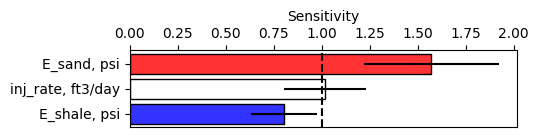

In [75]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

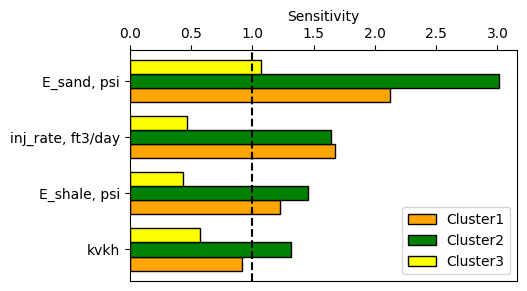

In [76]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'blue', 'red', 'black']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=4, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

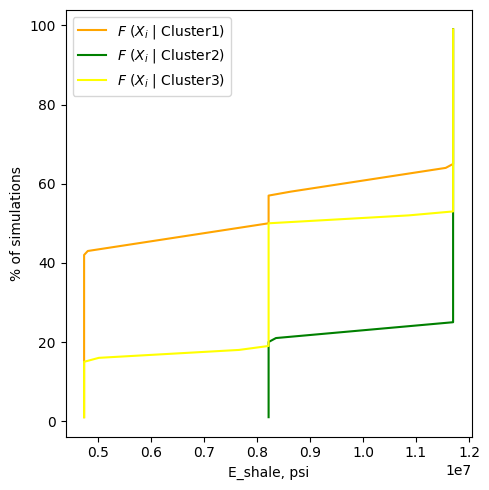

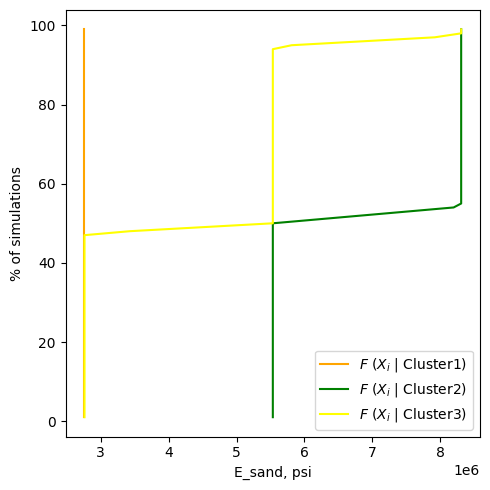

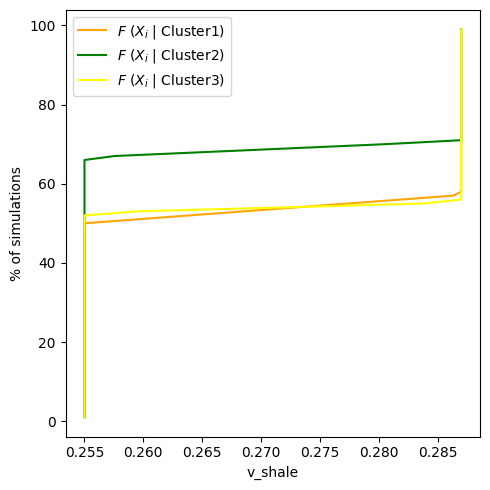

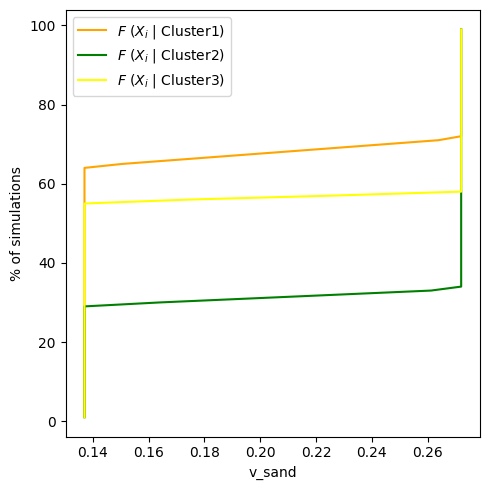

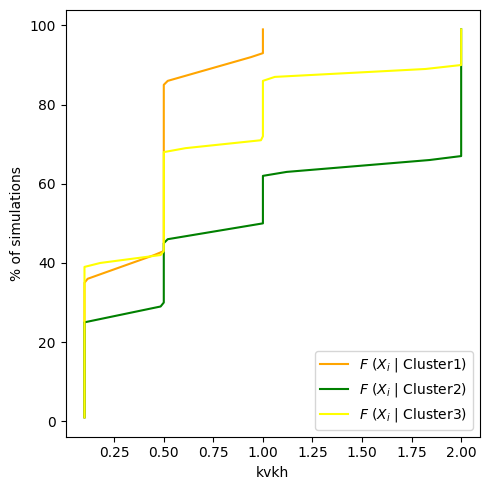

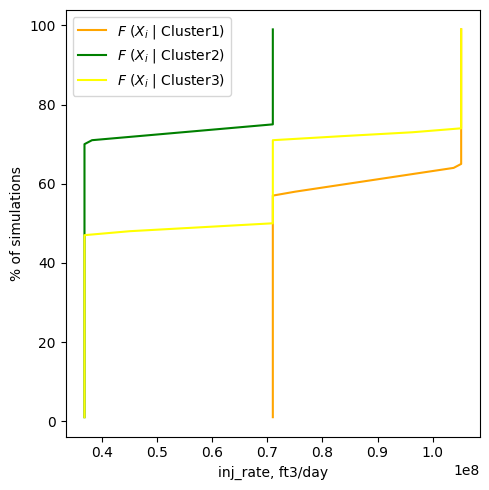

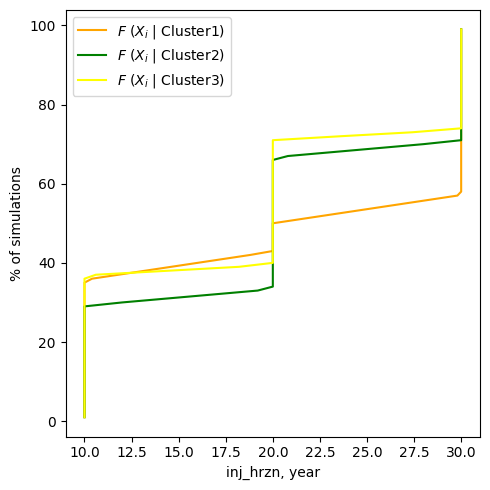

In [80]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

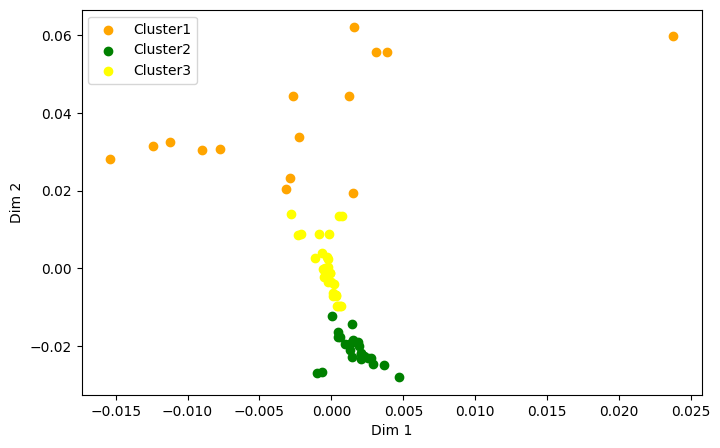

In [81]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

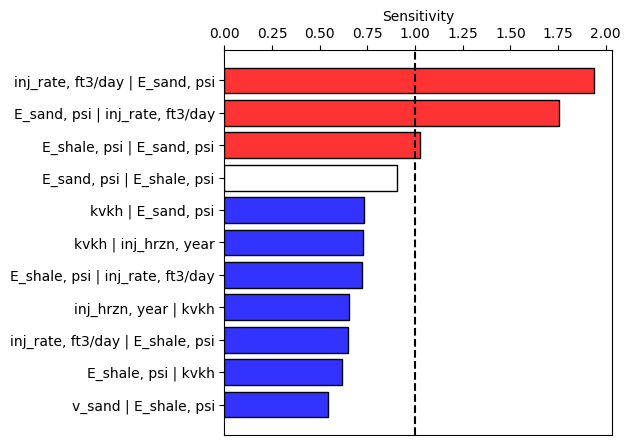

In [82]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

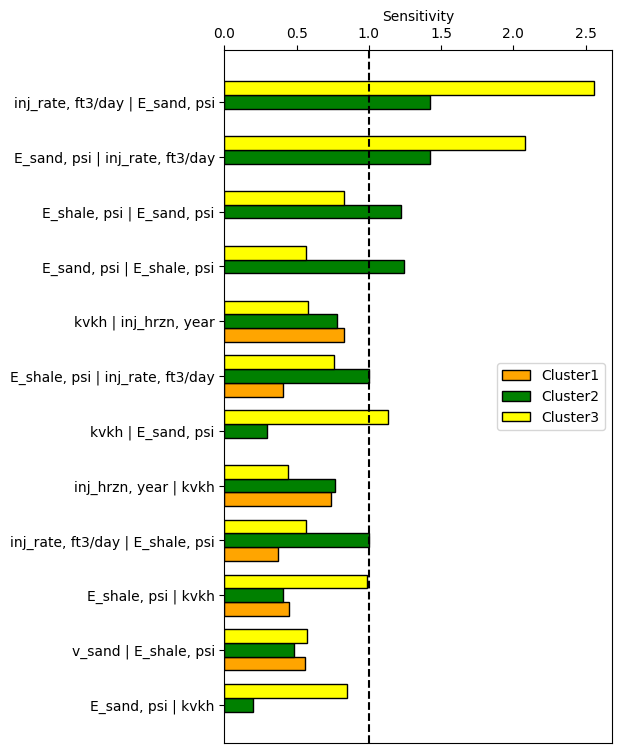

In [83]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

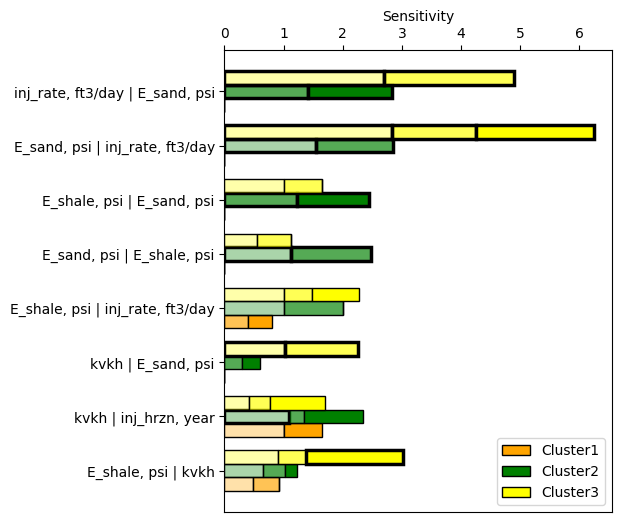

In [84]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)